<div class="alert alert-danger" style="color:black"><b>Running ML-LV Jupyter Notebooks:</b><br>
    <ol>
        <li>Make sure you are running all notebooks using the <code>adv_ai</code> kernel.
        <li><b>It is very important that you do not create any additional files within the weekly folders on CSCT cloud.</b> Any additional files, or editing the notebooks with a different environment may prevent submission/marking of your work.</li>
            <ul>
                <li>NBGrader will automatically fetch and create the correct folders files for you.</li>
                <li>All files that are not the Jupyter notebooks should be stored in the 'ML-LV/data' directory.</li>
            </ul>
        <li>Please <b>do not pip install</b> any python packages (or anything else). You should not need to install anything to complete these notebooks other than the packages provided in the Jupyter CSCT Cloud environment.</li>
    </ol>
    <b>If you would like to run this notebook locally you should:</b><br>
    <ol>
        <li>Create an environment using the requirements.txt file provided. <b>Any additional packages you install will not be accessible when uploaded to the server and may prevent marking.</b></li>
        <li>Download a copy  of the notebook to your own machine. You can then edit the cells as you wish and then go back and copy the code into/edit the ones on the CSCT cloud in-place.</li>
        <li><b>It is very important that you do not re-upload any notebooks that you have edited locally.</b> This is because NBGrader uses cell metadata to track marked tasks. <b>If you change this format it may prevent marking.</b></li>
    </ol>
</div>

# Practical 11: Image Segmentation

In the previous practical we applied CNN's to object detection which localises and classifies one or more objects within an image. Object detection is closely linked with image segmentation, which assigns a class label to each pixel of an image. *Semantic* segmentation identifies each class (objects and background) within an image and overlays with a segmentation mask. *Instance* segmentation identifies individual objects within an image and overlays each with a separate segmentation mask. *Panoptic* segmentation combines semantic and instance by overlaying a mask for all individual objects and background components.

Image segmentation architectures often have many similarities with object recognition architectures. For example, with instance and panoptic segmentation the objects must first be localised before a segmentation mask can be generated.

In the first part of this practical we will introduce some traditional image segmentation techniques, such as thresholding, clustering and the watershed algorithm.

In the second part of this practical we will build and apply a U-Net CNN to perform semantic segmentation of the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).

The objectives of this practical are:

1. Consider the advantages and disadvantages of simpler, non-CNN-based image segmentation

2. Apply a complete MV workflow for semantic segmentation using U-Net architecture

3. Consider architectural configurations and appropriate metrics for evaluating image segmentation

# 1 Traditional Image Segmentation

## 1.0 Import libraries

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from sklearn.cluster import KMeans
%matplotlib inline

# Get the status of NBgrader (for skipping cell execution while validating/grading)
grading = True if os.getenv('NBGRADER_EXECUTION') else False

# Set seaborn style for matplotlib plots
plt.style.use('seaborn-v0_8-white')

# Get the project directory (should be in ML-LV)
path = ''
while os.path.basename(os.path.abspath(path)) != 'ML-LV':
    path = os.path.abspath(os.path.join(path, '..'))

# Set the directory to the shared images folder (should be in shared/images)
images_dir = os.path.join(path, '..', 'shared', 'images')

## 1.1 Threshold segmentation

Threshold value: 0.693
Multiple thresholds: [0.   0.25 0.5  0.75]


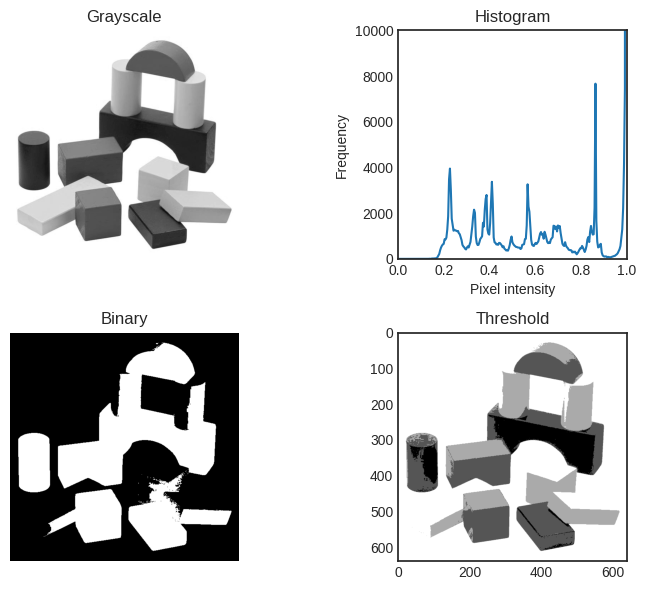

In [2]:
# Load the image
original = io.imread(os.path.join(images_dir, 'toy_blocks.jpg'))

# Convert to grayscale
grayscale = rgb2gray(original)

# Compute the histogram
histogram, bin_edges = np.histogram(grayscale, bins=256, range=(0.0, 1.0))

# Find the threshold value
thresh = threshold_otsu(grayscale)
print(f"Threshold value: {round(thresh, 4)}")

# Binarize the image, pixels with value > thresh are set to 1 (foreground), else 0 (background)
binary = (grayscale <= thresh).astype(int)

# Find multiple thresholds
multi_thresh = np.arange(0, 1.0, 1/4)
print(f"Multiple thresholds: {multi_thresh}")

# Threshold the image with multiple thresholds
threshold = np.digitize(grayscale, multi_thresh, right=False)

# Display the images
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
ax = ax.ravel()
ax[0].imshow(grayscale, cmap='gray')
ax[0].set_title("Grayscale")
ax[0].axis('off')

ax[1].plot(bin_edges[0:-1], histogram)
ax[1].set_title("Histogram")
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 10000])
ax[1].set_xlabel("Pixel intensity")
ax[1].set_ylabel("Frequency")
asp = np.diff(ax[1].get_xlim())[0] / np.diff(ax[1].get_ylim())[0]
ax[1].set_aspect(asp)

ax[2].imshow(binary, cmap='gray')
ax[2].set_title("Binary")
ax[2].axis('off')

ax[3].imshow(threshold, cmap='gray')
ax[3].set_title("Threshold")

fig.tight_layout()
plt.show()

## 1.2 K-means segmentation

Original image shape: (640, 640, 3)
Reshaped image shape: (409600, 3)


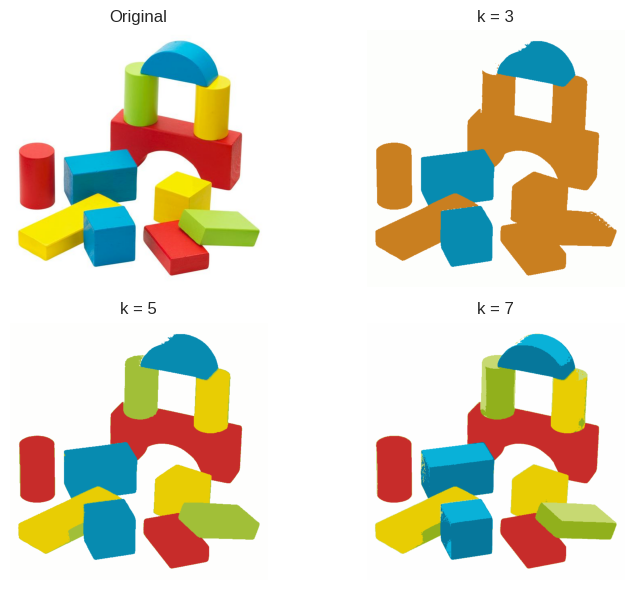

In [3]:
# Load the image
original = io.imread(os.path.join(images_dir, 'toy_blocks.jpg'))

# Convert to range [0, 1]
image = original / 255.0
# Reshape to a 2D array of pixels and 3 color values (RGB)
image = image.reshape((-1, 3))
print(f"Original image shape: {original.shape}")
print(f"Reshaped image shape: {image.shape}")

# Compute k-means for different values of k
k_clustered_images = []
k_values = [3, 5, 7]
for k in k_values:
    # Create  and fit the k-means model
    kmeans = KMeans(n_clusters=k, random_state=0).fit(image)
    # Get the cluster centers
    cluster_centers = kmeans.cluster_centers_
    # Get the labels for each pixel
    pixel_labels = cluster_centers[kmeans.labels_]
    # Reshape back to the original image dimension
    k_clustered_images.append(pixel_labels.reshape(original.shape))

# Display the images
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
ax = ax.ravel()
ax[0].imshow(original)
ax[0].set_title("Original")
ax[0].axis('off')
for i in range(len(k_values)):
    ax[i+1].imshow(k_clustered_images[i])
    ax[i+1].set_title("k = {}".format(k_values[i]))
    ax[i+1].axis('off')
fig.tight_layout()
plt.show()

## 1.3 Watershed
The watershed algorithm considers pixel values topographically, i.e. as ‘peaks’ and ‘valleys’ (local minima). It ‘floods’ (fills) the valleys with different colours and when two colours meet do not allow to mix. Once all the peaks are covered the image is segmented.

This code is adapted from [OpenCV](https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html).

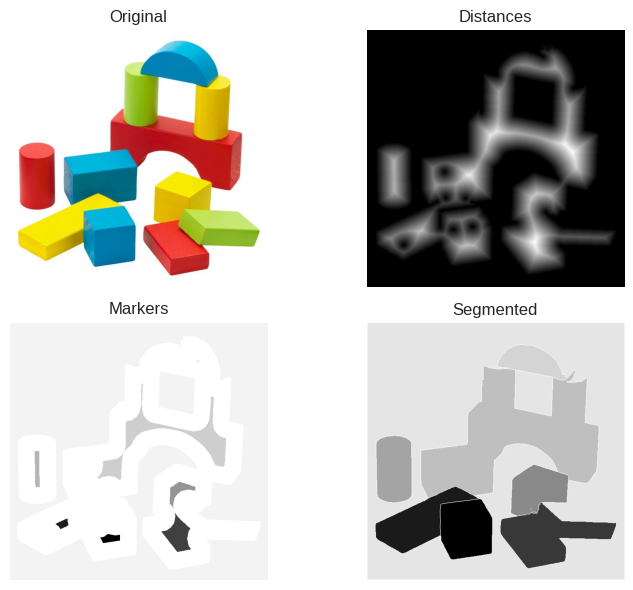

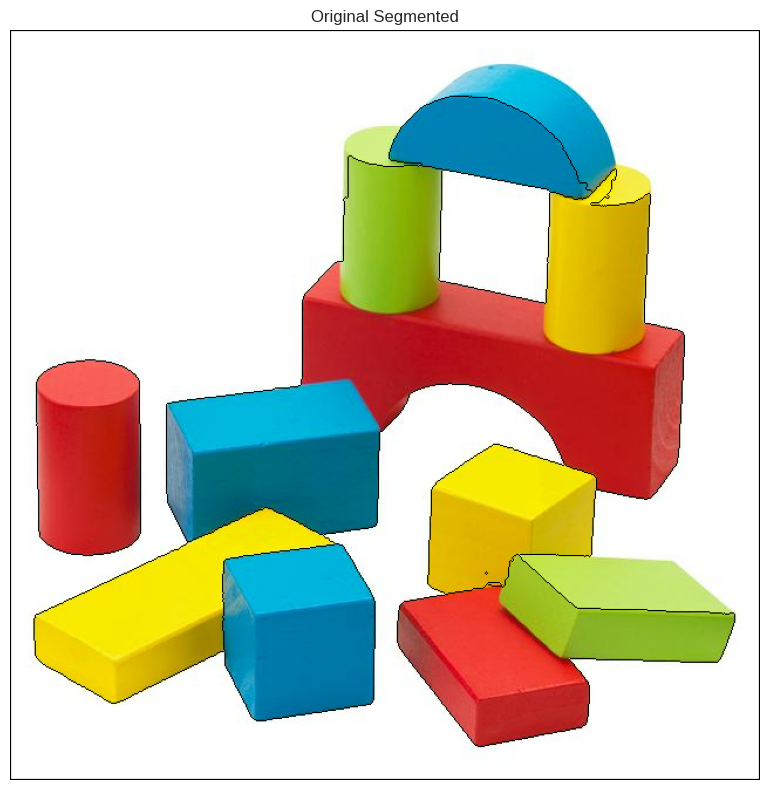

In [4]:
# Load the image
original = cv2.imread(os.path.join(images_dir, 'toy_blocks.jpg'), cv2.IMREAD_COLOR)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

# Convert to grayscale
grayscale = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

# Find the threshold value
ret, thresh = cv2.threshold(grayscale, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Remove noise
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)  # Erosion followed by dilation

# Find sure background area
sure_backg = cv2.dilate(opening, kernel, iterations=3)

# Find sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)  # The value of each pixel is replaced by its distance to the nearest background pixel
ret, sure_foreg = cv2.threshold(dist_transform, 0.6*dist_transform.max(), 255, 0)

# Finding unknown region
sure_foreg = np.uint8(sure_foreg)
unknown = cv2.subtract(sure_backg, sure_foreg)

# Find markers for the watershed algorithm by labeling the foreground objects
ret, markers = cv2.connectedComponents(sure_foreg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown == 255] = 0

# Perform watershed
watersh_markers = cv2.watershed(original.copy(), markers.copy())

# Display the images
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
ax = ax.ravel()
ax[0].imshow(original)
ax[0].set_title("Original")
ax[0].axis('off')

ax[1].imshow(dist_transform, cmap='gray')
ax[1].set_title("Distances")
ax[1].axis('off')

ax[2].imshow(markers)
ax[2].set_title("Markers")
ax[2].axis('off')

ax[3].imshow(watersh_markers)
ax[3].set_title("Segmented")
ax[3].axis('off')

fig.tight_layout()
plt.show()

# Show the segmented image
original[watersh_markers == -1] = [0, 0, 0]
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(original)
ax.set_title("Original Segmented")
ax.axis('off')
fig.tight_layout()
plt.show()

<div class="alert alert-success" style="color:black"><h3>Before you submit this notebook to NBGrader for marking:</h3> 

1. Make sure have completed all exercises marked by <span style="color:blue">**blue cells**</span>.
2. For automatically marked exercises ensure you have completed any cells with `# YOUR CODE HERE`. Then click 'Validate' button above, or ensure all cells run without producing an error.
3. For manually marked exercises ensure you have completed any cells with `"YOUR ANSWER HERE"`.
4. Ensure all cells are run with their output visible.
5. Fill in your student ID (**only**) below.
6. You should now **save and download** your work.

</div>

**Student ID:** 15006280